In [11]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pprint import pformat

from hloc import extract_features, match_features, pairs_from_covisibility, pairs_from_retrieval, pairs_from_poses
from hloc import colmap_from_nvm, reconstruction, triangulation, localize_sfm, visualization

from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pipeline for ANA image data

## Setup
Here we declare the paths to the dataset, the reconstruction and localization outputs, and we choose the feature extractor and the matcher. 

In [12]:
# Inputs for which map and which camera num
map_num = 4
camera_num = 0

# All directories
ana_root = Path('/home/ubuntu/Anantak')
ana_sitemap_dir = ana_root / 'SensorUnit/data/Map'
ana_pipelines_dir = ana_root / 'SensorUnit/data/Pipelines'
pipelines_location_dir = ana_pipelines_dir / f'SiteMap_{map_num:03d}/'
site_map__camera__recording_dir = pipelines_location_dir / 'recording'
site_map__camera__images_dir = pipelines_location_dir / 'recording/images'
pipelines_output_dir = pipelines_location_dir / 'outputs/'

# Create directories that are missing
if not os.path.exists(pipelines_location_dir):
   os.makedirs(pipelines_location_dir)
if not os.path.exists(site_map__camera__recording_dir):
   os.makedirs(site_map__camera__recording_dir)
if not os.path.exists(site_map__camera__images_dir):
   os.makedirs(site_map__camera__images_dir)
if not os.path.exists(pipelines_output_dir):
   os.makedirs(pipelines_output_dir)

print(f'Location: {pipelines_location_dir}')
print(f'Recording: {site_map__camera__recording_dir}')
print(f'Images: {site_map__camera__images_dir}')
print(f'Outputs: {pipelines_output_dir}')

# Run ANA Map Editor to export initial colmap data
ana_map_edtor_export_cmd = f"{ana_root}/SensorUnit/_install/bin/test_map_edit_app --load_map_num={map_num}  --export_for_colmap_dir=\"{site_map__camera__recording_dir}\" --exit"
print(f'Map Editor cmd: {ana_map_edtor_export_cmd}')
os.system(ana_map_edtor_export_cmd)


Location: /home/ubuntu/Anantak/SensorUnit/data/Pipelines/SiteMap_004
Recording: /home/ubuntu/Anantak/SensorUnit/data/Pipelines/SiteMap_004/recording
Images: /home/ubuntu/Anantak/SensorUnit/data/Pipelines/SiteMap_004/recording/images
Outputs: /home/ubuntu/Anantak/SensorUnit/data/Pipelines/SiteMap_004/outputs
Map Editor cmd: /home/ubuntu/Anantak/SensorUnit/_install/bin/test_map_edit_app --load_map_num=4  --export_for_colmap_dir="/home/ubuntu/Anantak/SensorUnit/data/Pipelines/SiteMap_004/recording" --exit
Building MapEditor with 6 cameras per rigframe
  Loading zone definition file: /home/ubuntu/Anantak/SensorUnit/data/Map/Zones/zone_definition_2001_orpor_PRE_metro_exclude_trucks_on_left.json
  Loading zone definition file: /home/ubuntu/Anantak/SensorUnit/data/Map/Zones/zone_definition_8400_orpor_SLOW_zone.json
  Loading zone definition file: /home/ubuntu/Anantak/SensorUnit/data/Map/Zones/zone_definition_8210_orpor_metro_exclude_trucks_on_right.json
  Loading zone definition file: /home/u

I1130 14:30:36.263736 39763 apriltags_detector.cu:621] Reading the file /home/ubuntu/Anantak/SensorUnit/config/apriltags_calibration_target_large.cfg
I1130 14:30:36.264851 39763 apriltags_detector.cu:653] Loaded calibration target with name = AprilTagsCalibrationTarget with 35 tags


    Created timed circular queue. Provided size = 16384. size = 16384 mask = 16383 = 3fff
    Created timed circular queue. Provided size = 16384. size = 16384 mask = 16383 = 3fff
    Created timed circular queue. Provided size = 128. size = 128 mask = 127 = 7f
    Created timed circular queue. Provided size = 1024. size = 1024 mask = 1023 = 3ff
    Created timed circular queue. Provided size = 1024. size = 1024 mask = 1023 = 3ff
    Created timed circular queue. Provided size = 1024. size = 1024 mask = 1023 = 3ff
    Created timed circular queue. Provided size = 4096. size = 4096 mask = 4095 = fff
    Created timed circular queue. Provided size = 128. size = 128 mask = 127 = 7f
    Created timed circular queue. Provided size = 1024. size = 1024 mask = 1023 = 3ff
    Created timed circular queue. Provided size = 1024. size = 1024 mask = 1023 = 3ff
    Created timed circular queue. Provided size = 1024. size = 1024 mask = 1023 = 3ff
    Created timed circular queue. Provided size = 1024

0

In [13]:
dataset = pipelines_location_dir  # change this if your dataset is somewhere else
images = site_map__camera__images_dir

outputs = pipelines_output_dir  # where everything will be saved
sfm_pairs = outputs / 'pairs-db-covis20.txt'  # top 20 most covisible in SIFT model
loc_pairs = outputs / 'pairs-query-netvlad20.txt'  # top 20 retrieved by NetVLAD
reference_sfm = outputs / 'sfm_superpoint+superglue'  # the SfM model we will build
results = outputs / 'Aachen_hloc_superpoint+superglue_netvlad20.txt'  # the result file
sfm_dir = outputs / 'sfm'

# list the standard configurations available
print(f'Configs for feature extractors:\n{pformat(extract_features.confs)}')
print(f'Configs for feature matchers:\n{pformat(match_features.confs)}')

Configs for feature extractors:
{'cosplace': {'model': {'name': 'cosplace'},
              'output': 'global-feats-cosplace',
              'preprocessing': {'resize_max': 1024}},
 'd2net-ss': {'model': {'multiscale': False, 'name': 'd2net'},
              'output': 'feats-d2net-ss',
              'preprocessing': {'grayscale': False, 'resize_max': 1600}},
 'dir': {'model': {'name': 'dir'},
         'output': 'global-feats-dir',
         'preprocessing': {'resize_max': 1024}},
 'disk': {'model': {'max_keypoints': 5000, 'name': 'disk'},
          'output': 'feats-disk',
          'preprocessing': {'grayscale': False, 'resize_max': 1600}},
 'netvlad': {'model': {'name': 'netvlad'},
             'output': 'global-feats-netvlad',
             'preprocessing': {'resize_max': 1024}},
 'openibl': {'model': {'name': 'openibl'},
             'output': 'global-feats-openibl',
             'preprocessing': {'resize_max': 1024}},
 'r2d2': {'model': {'max_keypoints': 5000, 'name': 'r2d2'},
        

In [14]:
# pick one of the configurations for image retrieval, local feature extraction, and matching
# you can also simply write your own here!
retrieval_conf = extract_features.confs['netvlad']
feature_conf = extract_features.confs['disk']
matcher_conf = match_features.confs['disk+lightglue']

## Extract local features for database and query images

In [15]:
features = extract_features.main(feature_conf, images, outputs)

[2023/11/30 14:32:39 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}


[2023/11/30 14:32:39 hloc INFO] Found 149 images in root /home/ubuntu/Anantak/SensorUnit/data/Pipelines/SiteMap_004/recording/images.
100%|██████████| 149/149 [00:05<00:00, 28.26it/s]
[2023/11/30 14:32:47 hloc INFO] Finished exporting features.


The function returns the path of the file in which all the extracted features are stored.

Features were exported to file: /home/ubuntu/Anantak/SensorUnit/data/Pipelines/SiteMap_004/outputs/feats-disk.h5


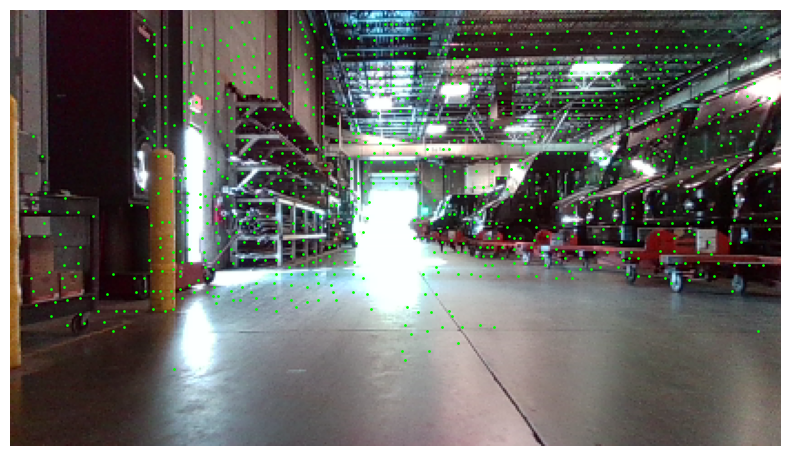

In [16]:
# This is the file where the features were saved
print(f'Features were exported to file: {features}')

# How can we plot the exported features?
from hloc.utils.io import list_h5_names, read_image, get_keypoints
from hloc.utils.viz import plot_images, plot_keypoints

sample_image_names_list = list_h5_names(features)

sample_idx = 3
sample_image_name = sample_image_names_list[sample_idx] #'db/1931.jpg'
sample_image_path = images / sample_image_name
sample_image = read_image(sample_image_path)
sample_image_kps = get_keypoints(features, sample_image_name)

plot_images([sample_image])
plot_keypoints([sample_image_kps])


## Generate pairs for the SfM reconstruction
Instead of matching all database images exhaustively, we exploit the existing SIFT model to find which image pairs are the most covisible. We first convert the SIFT model from the NVM to the COLMAP format, and then do a covisiblity search, selecting the top 20 most covisibile neighbors for each image.

In [18]:
# Create pairs using initial poses
pairs_from_poses.main(
  pipelines_location_dir / 'recording',
  sfm_pairs, 
  num_matched=10,
  use_text_file=True
)

[2023/11/30 14:33:54 hloc INFO] Reading the COLMAP model...
[2023/11/30 14:33:54 hloc INFO] Obtaining pairwise distances between 149 images...
[2023/11/30 14:33:54 hloc INFO] Found 1480 pairs.


## Match the database images

In [19]:
sfm_matches = match_features.main(matcher_conf, sfm_pairs, feature_conf['output'], outputs)

print(f'sfm matches were saved in file {sfm_matches}')

[2023/11/30 14:34:16 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}


100%|██████████| 802/802 [00:25<00:00, 31.15it/s]
[2023/11/30 14:34:42 hloc INFO] Finished exporting matches.


sfm matches were saved in file /home/ubuntu/Anantak/SensorUnit/data/Pipelines/SiteMap_004/outputs/feats-disk_matches-disk-lightglue_pairs-db-covis20.h5


The function returns the path of the file in which all the computed matches are stored.

## Triangulate a new SfM model from the given poses
We triangulate the sparse 3D pointcloud given the matches and the reference poses stored in the SIFT COLMAP model.

In [20]:
# Reconstruction from matches

model = reconstruction.main(
    sfm_dir, 
    images, 
    sfm_pairs, 
    features, 
    sfm_matches)


[2023/11/30 14:35:15 hloc INFO] Creating an empty database...


[2023/11/30 14:35:15 hloc INFO] Importing images into the database...
[2023/11/30 14:35:16 hloc INFO] Importing features into the database...
100%|██████████| 149/149 [00:00<00:00, 2191.82it/s]
[2023/11/30 14:35:16 hloc INFO] Importing matches into the database...
100%|██████████| 1480/1480 [00:00<00:00, 2691.92it/s]
[2023/11/30 14:35:17 hloc INFO] Performing geometric verification of the matches...
[2023/11/30 14:35:18 hloc INFO] Running 3D reconstruction...
W1130 14:35:30.768808 40235 levenberg_marquardt_strategy.cc:115] Linear solver failure. Failed to compute a step: Eigen failure. Unable to perform dense Cholesky factorization.
W1130 14:35:30.773579 40235 levenberg_marquardt_strategy.cc:115] Linear solver failure. Failed to compute a step: Eigen failure. Unable to perform dense Cholesky factorization.
W1130 14:35:34.031340 40235 levenberg_marquardt_strategy.cc:115] Linear solver failure. Failed to compute a step: Eigen failure. Unable to perform dense Cholesky factorization.
W1130

In [21]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

## Find image pairs via image retrieval
We extract global descriptors with NetVLAD and find for each image the $k$ most similar ones. A larger $k$ improves the robustness of the localization for difficult queries but makes the matching more expensive. Using $k{=}10{-}20$ is generally a good tradeoff but $k{=}50$ gives the best results for the Aachen Day-Night dataset.

In [36]:
global_descriptors = extract_features.main(retrieval_conf, images, outputs)
pairs_from_retrieval.main(global_descriptors, loc_pairs, num_matched=20, db_prefix="db", query_prefix="query")

[2023/11/24 10:20:37 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2023/11/24 10:20:37 hloc INFO] Found 5426 images in root datasets/aachen/images_upright.
100%|██████████| 5426/5426 [09:10<00:00,  9.85it/s]
[2023/11/24 10:29:54 hloc INFO] Finished exporting features.
[2023/11/24 10:29:54 hloc INFO] Extracting image pairs from a retrieval database.
[2023/11/24 10:30:04 hloc INFO] Found 18940 pairs.


## Match the query images

In [37]:
loc_matches = match_features.main(matcher_conf, loc_pairs, feature_conf['output'], outputs)

[2023/11/24 10:58:22 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


 65%|██████▍   | 12263/18940 [1:56:32<1:03:27,  1.75it/s]

: 

## Localize!
Perform hierarchical localization using the precomputed retrieval and matches. The file `Aachen_hloc_superpoint+superglue_netvlad50.txt` will contain the estimated query poses. Have a look at `Aachen_hloc_superpoint+superglue_netvlad50.txt_logs.pkl` to analyze some statistics and find failure cases.

In [ ]:
localize_sfm.main(
    reconstruction,
    dataset / 'queries/*_time_queries_with_intrinsics.txt',
    loc_pairs,
    features,
    loc_matches,
    results,
    covisibility_clustering=False)  # not required with SuperPoint+SuperGlue

## Visualizing the SfM model
We visualize some of the database images with their detected keypoints.

Color the keypoints by track length: red keypoints are observed many times, blue keypoints few.

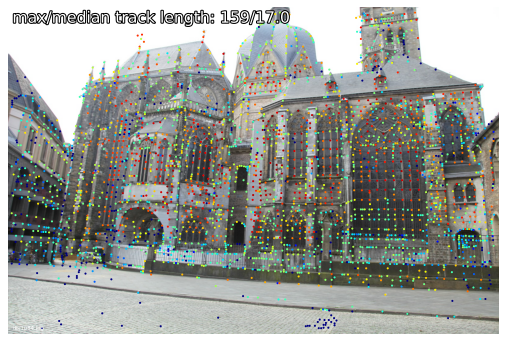

In [22]:
visualization.visualize_sfm_2d(reconstruction, images, n=1, color_by='track_length')

Color the keypoints by visibility: blue if sucessfully triangulated, red if never matched.

In [ ]:
visualization.visualize_sfm_2d(reconstruction, images, n=1, color_by='visibility')

Color the keypoints by triangulated depth: red keypoints are far away, blue keypoints are closer.

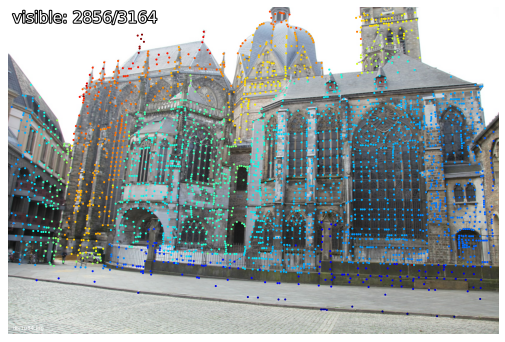

In [20]:
visualization.visualize_sfm_2d(reconstruction, images, n=1, color_by='depth')

## Visualizing the localization
We parse the localization logs and for each query image plot matches and inliers with a few database images.

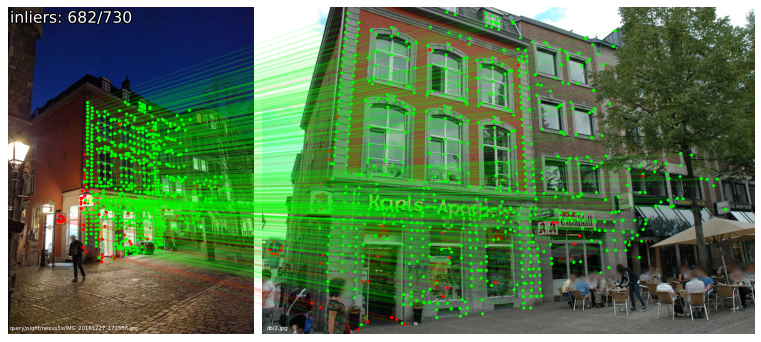

In [10]:
visualization.visualize_loc(
    results, images, reconstruction, n=1, top_k_db=1, prefix='query/night', seed=2)